## Clustering with K-Means

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt

In [2]:
X, y = datasets.make_blobs(n_samples=1000, n_features=2, centers=5, cluster_std=[0.5, 0.5, 0.5, 1, 1])

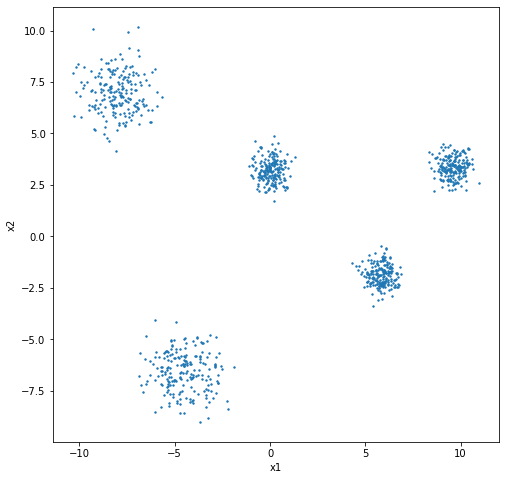

In [3]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], s=2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [4]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [5]:
y_pred is kmeans.labels_

True

In [7]:
# 5 centroids found
kmeans.cluster_centers_

array([[-4.52481805, -6.57307638],
       [ 0.03123493,  3.21548088],
       [ 5.79886497, -1.85801733],
       [-8.00315239,  6.97139488],
       [ 9.58771644,  3.36895905]])

In [10]:
import numpy as np
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])

In [11]:
kmeans.predict(X_new)

array([1, 1, 1, 1])

In [12]:
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [13]:
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

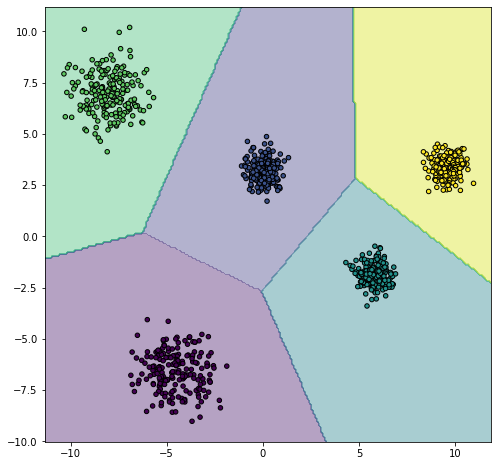

In [14]:
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=20, edgecolor='k')
plt.show()

In [15]:
# distance from each instance to every centroid
kmeans.transform(X_new)

array([[ 9.69389586,  1.21588215,  6.96499337,  9.42152935,  9.68495511],
       [11.40703841,  3.20795259,  4.76633432, 12.07410989,  6.72845129],
       [ 9.69375373,  3.03888421, 10.05088837,  6.38776261, 12.59312257],
       [ 9.2003144 ,  3.11453016,  9.81897855,  6.71006006, 12.61767391]])